# Introduction

## Foreword

Contains the best selected model applied to a testing set.

## Problem Statement

The rapid evolution of generative artificial intelligence (GPAI, LLMs) social media has rapidly increased the public’s access to powerful, deceptive tools. One such concern is the increasing prevalence of deepfake images, which pose a significant threat to public trust and undermines the epistemic integrity of visual media.

These manipulated images can be utilized to spread false information, manipulate public opinion, and polarize communities, which can have serious consequences for both social and political discourse. This project aims to develop a machine learning model that can detect differences between deepfakes and real images to combat the spread of manipulated visual media and protect the integrity of social discourse.

## Imports, Global Variables, and Helper Functions

In [1]:
import sys
sys.path.append("../../helper/")
import config

## Data Loading

In [2]:
test_directory = "../../../Data/Test/"

test_ds = config.image_dataset_from_directory(
    directory=test_directory,
    image_size=(256, 256),
    batch_size=64,
    seed=42,
    label_mode="binary",
    labels="inferred"
)

Found 10910 files belonging to 2 classes.


# Modeling

## Loading Model

In [3]:
model_path = "../../PretrainedModel/dffnetv2B0.json"
weights_path = "../../PretrainedModel/dffnetv2B0_weights.h5"

model = config.load_trained_model(model_path, weights_path)

## Read in Evaluation CSVs

The following csv files contain the training and validation metrics for several of our highest performing models and the training history of our best performing model.

#### Training History of Best Model

In [16]:
df_v2 = config.pd.read_csv("../../Results/v2b0_history.csv")
df_v2.drop(columns="Unnamed: 0", inplace=True)
df_v2.tail()


,loss,acc,val_loss,val_acc
5,0.017042,0.994386,0.116809,0.961398
6,0.011981,0.996143,0.109179,0.964873
7,0.008667,0.997243,0.114847,0.965532
8,0.006824,0.997772,0.104951,0.968981
9,0.005208,0.998536,0.119601,0.965126


#### Training and Validation Metrics Compared

In [27]:
df = config.pd.read_csv("../../Results/model_eval.csv", index_col='models')

**Looking at the validation accuracy and precision, the clear choice of our best model is "efficientnetv2-b0_retrain". This model is the smallest available efficientnetv2 model in the keras API. The weights of this model were initialized with the "imagenet" weights, but retrained on our deepfake classification dataset.**

In [28]:
df[["val_loss", "val_acc"]]

,val_loss,val_acc
models,,
cnn_tuned,0.260117,0.918135
effnetv2L,0.286400,0.891167
effnetv2b0,0.119601,0.965126
cnn_benchmark,0.421600,0.821600


## Evaluation on Test Set

When evaluated on the test dataset, the binary accuracy was reduced to 0.858 indicating that the model may not generalize particularly well to new data. It should be noted, however, that the test dataset also contains a much higher concentration of images that have been subject to various manipulations including blurring, adding gaussian noise to pixel values, removal of random pixels, and other transformations meant to decieve deepfake detection models.

In [7]:
test_scores = model.evaluate(test_ds)

2023-05-21 21:18:57.593108: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-21 21:18:57.593736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


171/171 [==============================] - 63s 361ms/step - loss: 0.5126 - binary_accuracy: 0.8577 - auc: 0.9387 - precision: 0.9188 - recall: 0.7828 - true_negatives: 5117.0000 - true_positives: 4241.0000 - false_positives: 375.0000 - false_negatives: 1177.0000


In [9]:
df_test_scores = config.pd.DataFrame(test_scores)
df_train_scores = config.pd.DataFrame(df.loc['efficientnetv2-b0_retrain'][:9])
df_val_scores = config.pd.DataFrame(df.loc['efficientnetv2-b0_retrain'][9:])

df_scores = config.pd.DataFrame(config.np.hstack([df_train_scores.values, 
                                                  df_val_scores.values, 
                                                  df_test_scores.values]), 
                                columns=["Train", 
                                        "Validation", 
                                        "Test"]).T

df_scores.columns = model.metrics_names

In [10]:
df_scores[['loss', 'binary_accuracy']]

,loss,binary_accuracy
Train,0.003119,0.977746
Validation,0.119601,0.965126
Test,0.512644,0.857745


## Graphing

#### Set Plot Style

In [154]:
import seaborn as sns
sns.set_style('whitegrid')

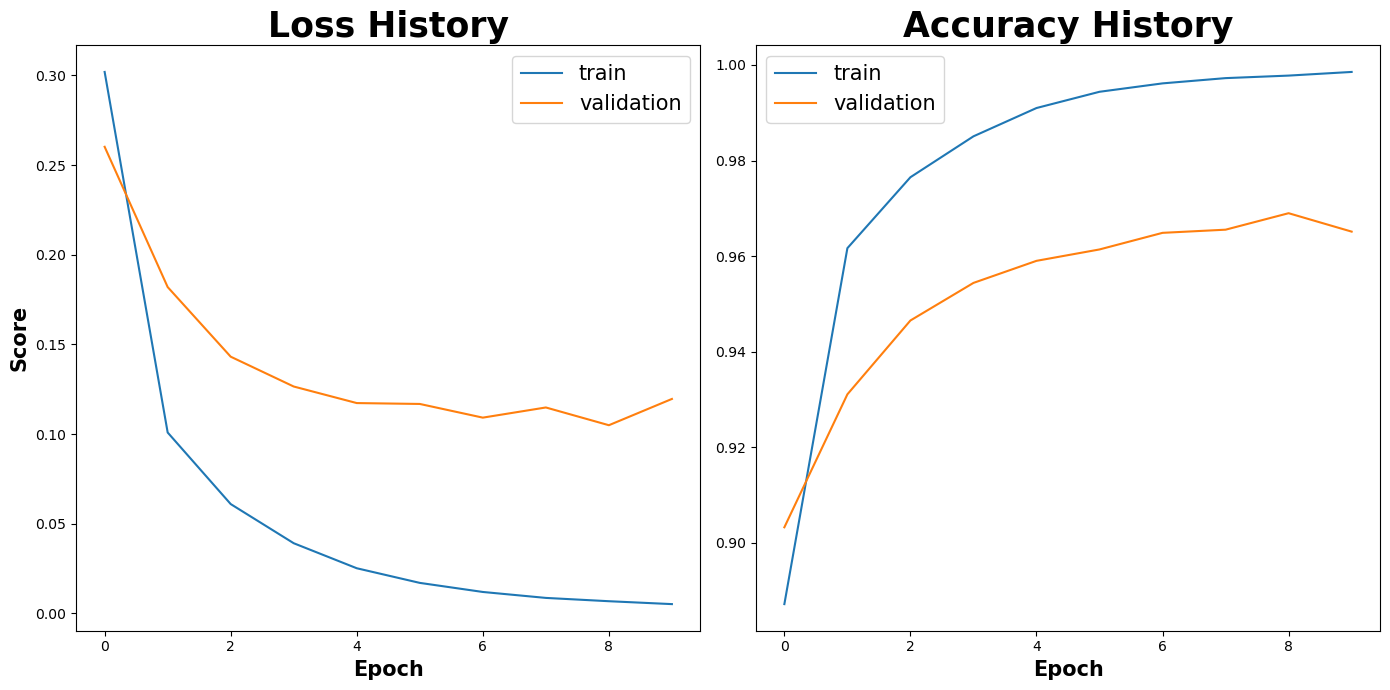

In [33]:
# Configure figure and plots
fig, ax = config.plt.subplots(1, 2, figsize=config.subplot_fig_size)

# Create data lists for graphing to loop over
titles = ["Loss History", "Accuracy History"]
data = ["loss", "acc"]
val_data = ["val_loss", "val_acc"]

ax[0].set_ylabel("Score", **config.axis_title_font)
# Graphs the data
for i in range(len(ax)):
    ax[i].set_title(titles[i], **config.title_font)
    ax[i].set_xlabel("Epoch", **config.axis_title_font)
    ax[i].plot(df_v2[data[i]], label="train")
    ax[i].plot(df_v2[val_data[i]], label="validation")
    ax[i].legend(loc='best', **config.label_font)
config.plt.tight_layout()
config.plt.savefig("../../../Images/v2b0_history.png")
config.plt.show()

The plots above show the loss and accuracy of the model at each of the 10 epochs of training. While There is some divergence of both the loss and accuracy curves, indicating some overfitting, it is not as drastic as it appears in the plots above due to the y-axis ranges. Below is a visualization of the same curves on a 0-1 y-axis scale. Overfitting is still evident, but not as pronounced.

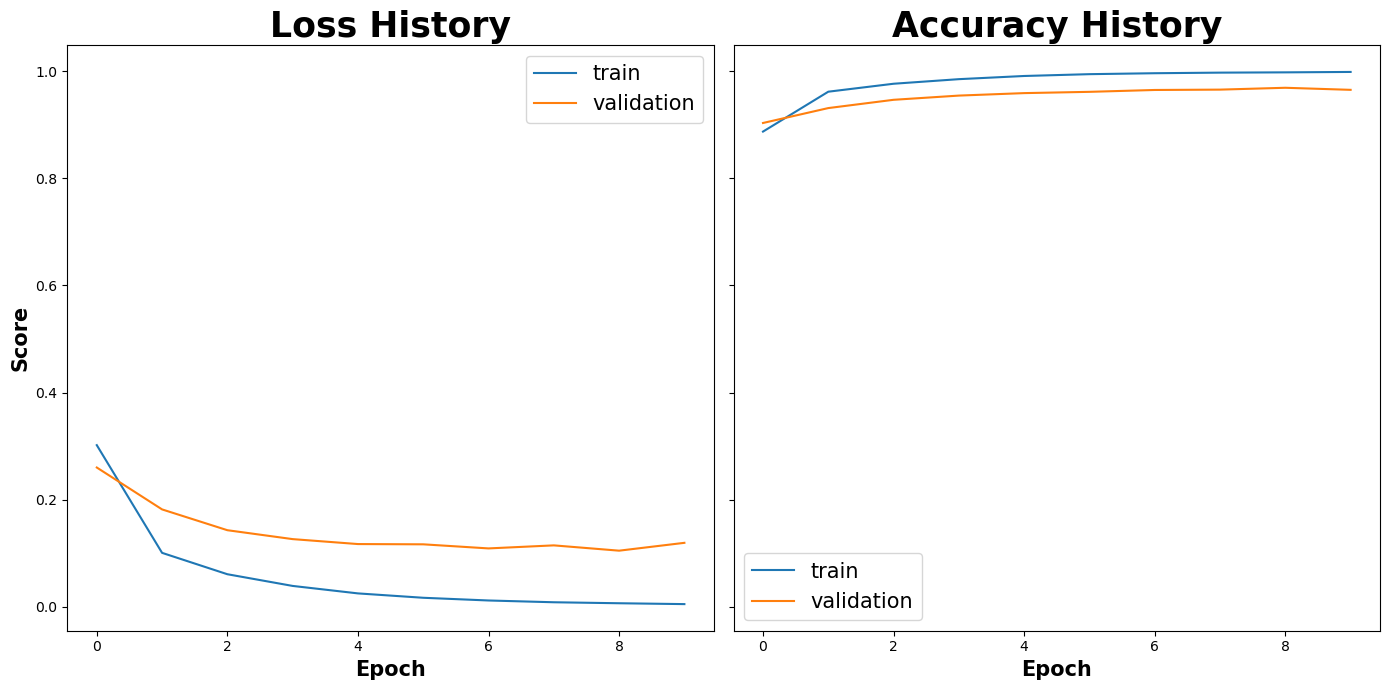

In [34]:
# Configure figure and plots
fig, ax = config.plt.subplots(1, 2, figsize=config.subplot_fig_size, sharey=True)

# Create data lists for graphing to loop over
titles = ["Loss History", "Accuracy History"]
data = ["loss", "acc"]
val_data = ["val_loss", "val_acc"]

ax[0].set_ylabel("Score", **config.axis_title_font)
# Graphs the data
for i in range(len(ax)):
    ax[i].set_title(titles[i], **config.title_font)
    ax[i].set_xlabel("Epoch", **config.axis_title_font)
    ax[i].plot(df_v2[data[i]], label="train")
    ax[i].plot(df_v2[val_data[i]], label="validation")
    ax[i].legend(loc='best', **config.label_font)
config.plt.tight_layout()
config.plt.show()

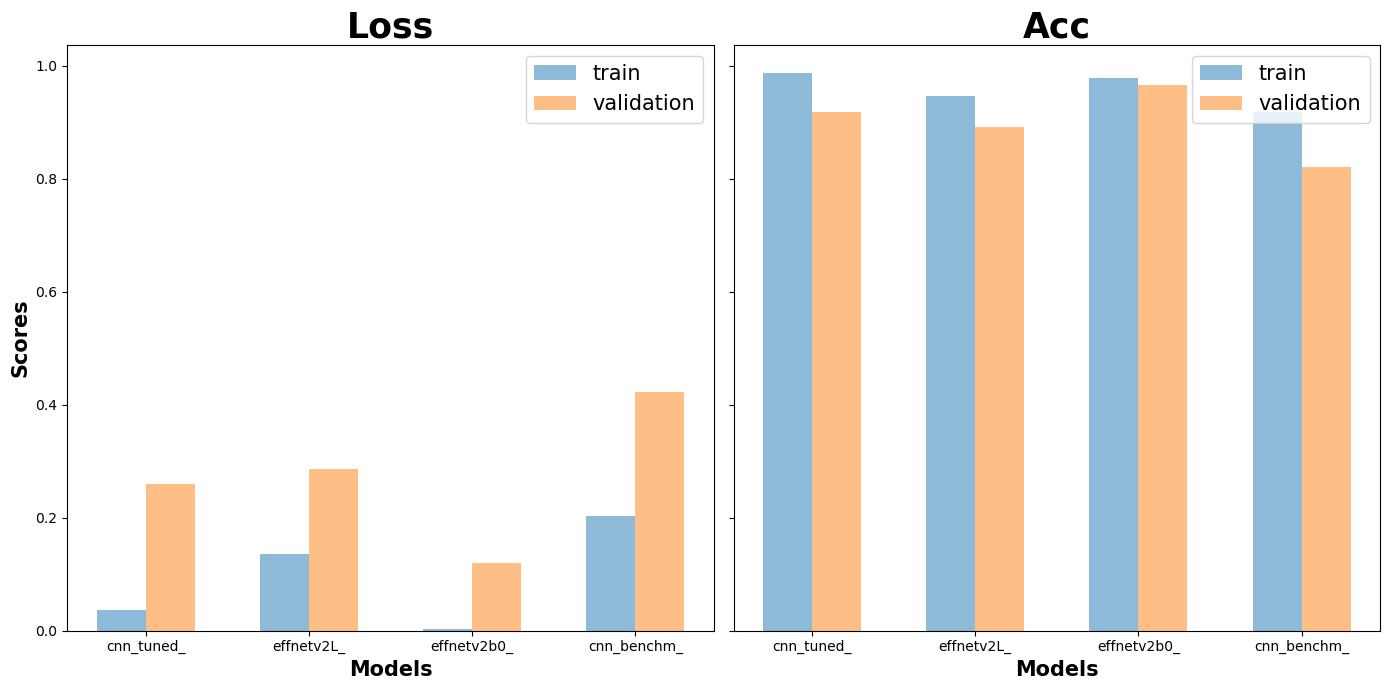

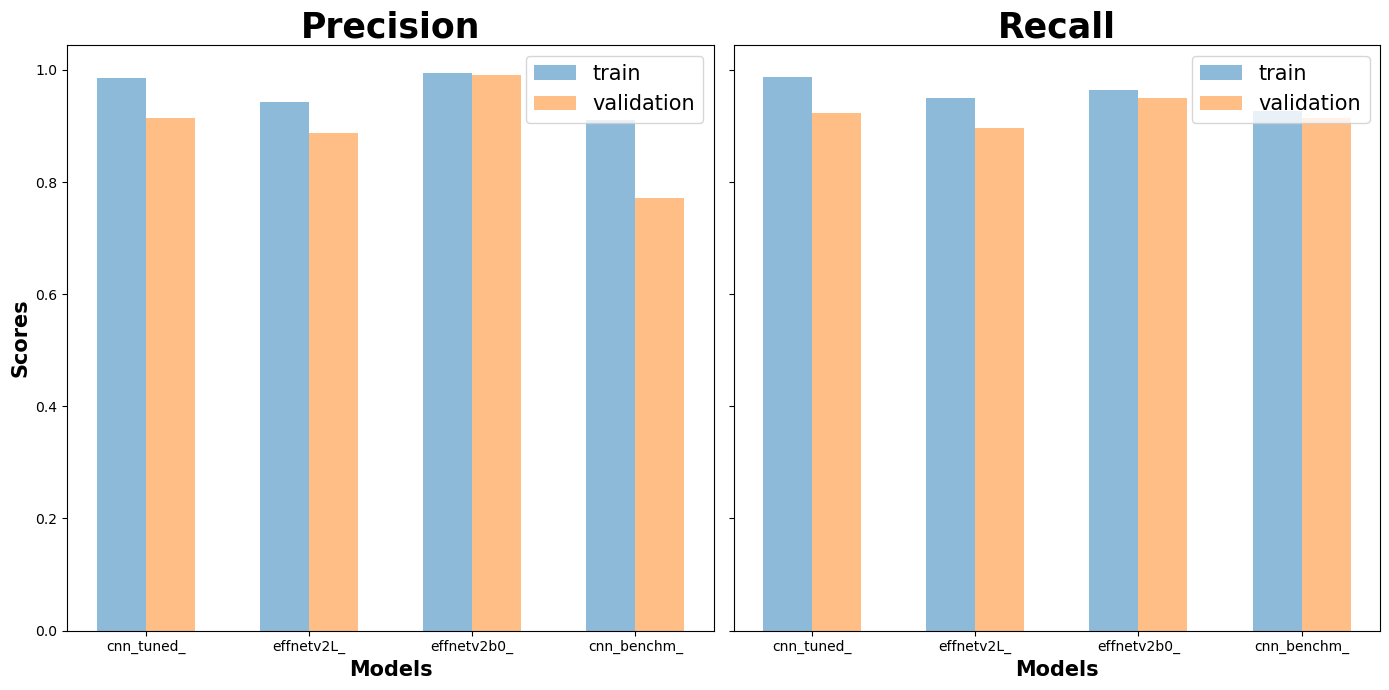

In [31]:
def plot_bar(df, list_of_columns):

    # Configure figure and plots
    total_graphs = len(list_of_columns)
    fig, ax = config.plt.subplots(1, total_graphs, figsize=config.subplot_fig_size, sharey=True)

    # Create data lists for graphing to loop over
    x_tick_labels = [f"{index[:10]}_" for index in df.index.to_list()]
    width = 0.3

    # Graphs the data
    ax[0].set_ylabel("Scores", **config.axis_title_font)
    for i in range(len(ax)):
        x_tick_indexes = config.np.arange(len(x_tick_labels))
        ax[i].set_title(f"{list_of_columns[i].title()}", **config.title_font)
        ax[i].set_xlabel("Models", **config.axis_title_font)
        ax[i].bar(x_tick_indexes, df[f"train_{list_of_columns[i]}"], width, label="train", alpha=0.5)
        ax[i].bar(x_tick_indexes + width, df[f"val_{list_of_columns[i]}"], width, label="validation", alpha=0.5)
        ax[i].set_xticks(x_tick_indexes + width / 2, x_tick_labels)
        ax[i].legend(loc='best', **config.label_font)
    config.plt.tight_layout()
    config.plt.savefig(f"../../../Images/{list_of_columns[0]}_{list_of_columns[1]}.png")
    config.plt.show()
    return

plot_bar(df, ["loss", "acc"])
plot_bar(df, ["precision", "recall"])

The curves above demonstrate a comparison of a selection of training and validation metrics for  some of our better performing models. Each x-tick is a different model whose training metrics are shown in blue and validation metrics in orange. The best model outperformed the rest of the models in every category (when evaluated on the validation dataset)